In [1]:
# Imports, always include this at the beginning

# No science without NumPy
import numpy as np

# Matplotlib for plotting
import matplotlib.pyplot as plt
%matplotlib notebook

# Of course we want Glotaran
import glotaran as gta
import glotaran.dataio
import os

In [2]:
# Load the data
dataset = gta.io.TimeExplicitFile("data.ascii").read("dataset1")
data = dataset.get()
time_axis = dataset.get_time_axis()
spectral_axis = dataset.get_spectral_axis()


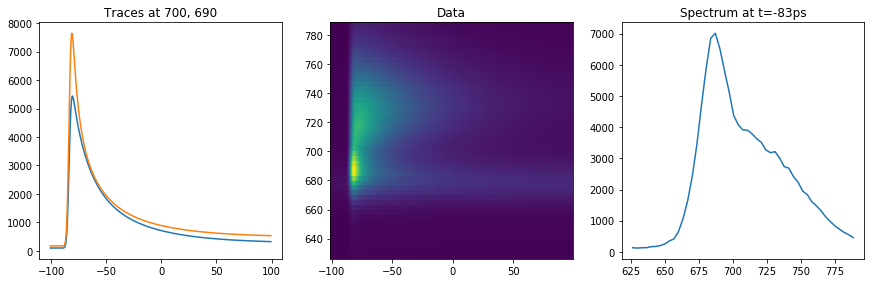

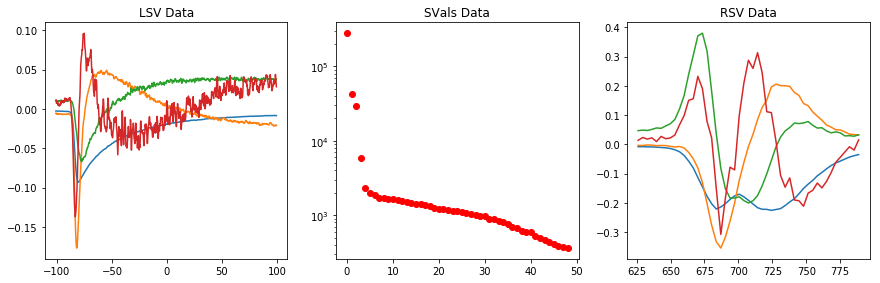

In [32]:
# Plot the Data

plt.figure(figsize=(20, 20))

# Plot some time traces
plt.subplot(4, 4, 1)
wl = [700, 690]
plt.title(f'Traces at {wl[0]}, {wl[1]}')
for w in wl:
    i = (np.abs(spectral_axis-w)).argmin()
    plt.plot(time_axis, data[i, :])

# Full Data
plt.subplot(4, 4, 2)
plt.title('Data')
plt.pcolormesh(time_axis, spectral_axis, data)

# Plot the spectrum at time=-83
time_zero = -83
time_zero_idx = (np.abs(time_axis-time_zero)).argmin()
plt.subplot(4, 4, 3)
plt.title('Spectrum at t=-83ps')
plt.plot(spectral_axis, data[:, time_zero_idx])


plt.figure(figsize=(20, 20))

lsvd, svals, rsvd = dataset.svd()

# Plot left singular vectors (LSV, times, first 4)
plt.subplot(4, 4, 1)
plt.title('LSV Data')
for i in range(4):
    plt.plot(time_axis, lsvd[:, i])

# Plot singular values (SV)
plt.subplot(4, 4, 2)
plt.title('SVals Data')
plt.plot(range(max(10, min(len(time_axis), len(spectral_axis)))), svals, 'ro')
plt.yscale('log')

# Plot right singular vectors (RSV, wavelengths, first 4)
plt.subplot(4, 4, 3)
plt.title('RSV Data')
for i in range(4):
    plt.plot(spectral_axis, rsvd[:, i])

In [4]:
# Then we can create our model

model_spec = '''
type: kinetic
parameters: 
  - initial_concentration:
    - [1, {vary: false}]
    - [0, {vary: false}]
    - [0, {vary: false}]
    - [0, {vary: false}]
  - irf:
    - ["center", -83.0]
    - ["width", 1.5]
    - [13200.0, "backsweep", {vary: false}]
  - kinetic:
    - 0.2
    - 0.07
    - 0.02
    - 0.00016
      
compartments: [s1, s2, s3, s4]

megacomplexes:
    - label: mc1
      k_matrices: [k1]
      
k_matrices:
  - label: "k1"
    matrix: {
      '("s2","s1")': kinetic.1,
      '("s3","s2")': kinetic.2,
      '("s4","s3")': kinetic.3,
      '("s4","s4")': kinetic.4
    }
    
irf:
  - label: irf
    type: gaussian
    center: irf.center
    width: irf.width
    backsweep: True
    backsweep_period: irf.backsweep

initial_concentration: #equal to the total number of compartments
  - label: inputD1
    parameter: [initial_concentration.1, initial_concentration.2, initial_concentration.3, initial_concentration.4] 
    
datasets:
  - label: dataset1
    type: spectral
    initial_concentration: inputD1
    megacomplexes: [mc1]
    path: ''
    irf: irf
'''

model = gta.parse(model_spec)
model.set_dataset("dataset1", dataset)
print(model)

Modeltype: Kinetic

Parameter
---------
Label	Value	Min	Max	Fix
	<Parameter 'p_initial_concentration_1', value=1.0 (fixed), bounds=[-inf:inf]>
	<Parameter 'p_initial_concentration_2', value=0.0 (fixed), bounds=[-inf:inf]>
	<Parameter 'p_initial_concentration_3', value=0.0 (fixed), bounds=[-inf:inf]>
	<Parameter 'p_initial_concentration_4', value=0.0 (fixed), bounds=[-inf:inf]>
	<Parameter 'p_irf_center', -83.0, bounds=[-inf:inf]>
	<Parameter 'p_irf_width', 1.5, bounds=[-inf:inf]>
	<Parameter 'p_irf_backsweep', value=13200.0 (fixed), bounds=[-inf:inf]>
	<Parameter 'p_kinetic_1', 0.2, bounds=[-inf:inf]>
	<Parameter 'p_kinetic_2', 0.07, bounds=[-inf:inf]>
	<Parameter 'p_kinetic_3', 0.02, bounds=[-inf:inf]>
	<Parameter 'p_kinetic_4', 0.00016, bounds=[-inf:inf]>


Compartments
-------------------------

['s1', 's2', 's3', 's4']

Megacomplexes
-------------

Label: mc1
K-Matrices: ['k1']

Initital Concentrations
-----------------------

Label: inputD1, Parameters, ['initial_concentration.1',

In [5]:
result = model.fit()

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.4944e+08                                    2.79e+11    
       1              2         5.2271e+07      1.97e+08       7.12e-01       3.93e+10    
       2              3         4.4028e+07      8.24e+06       2.64e-01       6.02e+09    
       3              4         4.3754e+07      2.73e+05       2.24e-02       3.50e+08    
       4              5         4.3750e+07      4.45e+03       2.87e-03       4.63e+07    
       5              6         4.3750e+07      9.38e+01       3.25e-04       2.87e+06    
       6              7         4.3750e+07      2.29e+00       4.62e-05       1.74e+06    
       7              8         4.3750e+07      5.67e-02       7.45e-06       1.47e+05    
       8              9         4.3750e+07      1.41e-03       1.12e-06       4.17e+04    
`ftol` termination condition is satisfied.
Function evaluations 9, initial cost 2.4944e+08

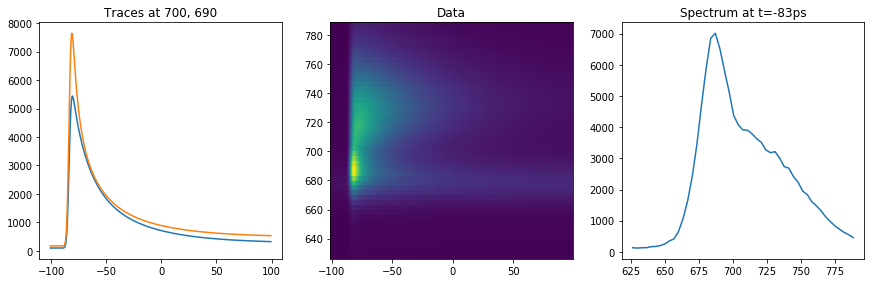

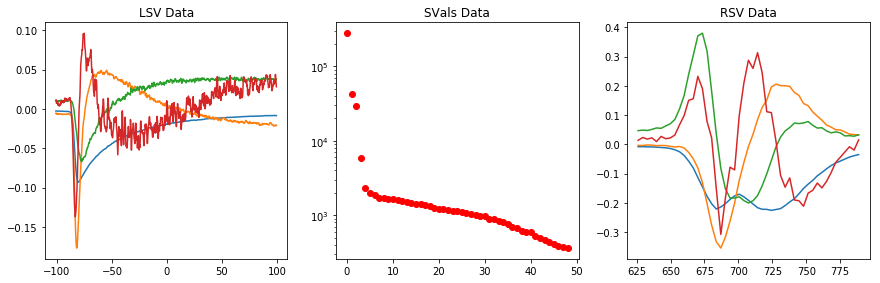

In [33]:
# Plot the fitted data

fitted_dataset = result.fitted_data('dataset1')
data = fitted_dataset.get()
# Plot the Data

plt.figure(figsize=(20, 20))

# Plot left singular vectors (LSV, times, first 4)
plt.subplot(4, 4, 1)
wl = [700, 690]
plt.title(f'Traces at {wl[0]}, {wl[1]}')
for w in wl:
    i = (np.abs(spectral_axis-w)).argmin()
    plt.plot(time_axis, data[i, :])

# Full Data
plt.subplot(4, 4, 2)
plt.title('Data')
plt.pcolormesh(time_axis, spectral_axis, data)

time_zero = -83
time_zero_idx = (np.abs(time_axis-time_zero)).argmin()
plt.subplot(4, 4, 3)
plt.title('Spectrum at t=-83ps')
plt.plot(spectral_axis, data[:, time_zero_idx])


plt.figure(figsize=(20, 20))

lsvd, svals, rsvd = dataset.svd()

# Plot left singular vectors (LSV, times, first 4)
plt.subplot(4, 4, 1)
plt.title('LSV Data')
for i in range(4):
    plt.plot(time_axis, lsvd[:, i])

# Plot singular values (SV)
plt.subplot(4, 4, 2)
plt.title('SVals Data')
plt.plot(range(max(10, min(len(time_axis), len(spectral_axis)))), svals, 'ro')
plt.yscale('log')

# Plot right singular vectors (RSV, wavelengths, first 4)
plt.subplot(4, 4, 3)
plt.title('RSV Data')
for i in range(4):
    plt.plot(spectral_axis, rsvd[:, i])